构建生成器和判别器

In [ ]:
import keras

In [ ]:
codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100,activation="selu",input_shape=[codings_size]),
    keras.layers.Dense(150,activation="selu"),
    keras.layers.Dense(28 * 28,activation="sigmoid"),
    keras.layers.Reshape([28,28])
])

discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(150,activation="selu"),
    keras.layers.Dense(100,activation="selu"),
    keras.layers.Dense(1,activation="sigmoid")
])

gan = keras.models.Sequential([generator,discriminator])

In [ ]:
discriminator.compile(loss="binary_crossentropy",optimizer="rmsprop")
discriminator.trainable=False
gan.compile(loss="binary_crossentropy",optimizer="rmsprop")

In [ ]:
import tensorflow as tf
from tensorflow import keras

# 导入fashion mnist
fashion_mnist = keras.datasets.fashion_mnist

# 加载数据集并划分训练集
(train_images, train_labels), (_, _) = fashion_mnist.load_data()


from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2)

# 将图像值缩放到 [0, 1] 的范围内
train_images = train_images.astype('float32') / 255.
test_images = test_images.astype('float32') / 255.


In [ ]:
import tensorflow as tf

batch_size = 256
dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(1000)
dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(10)

In [ ]:
def train_gan(gan,dataset,batch_size,codings_size,n_epochs=50):
  generator,discriminator = gan.layers
  for opoch in range(n_epochs):
    for X_batch in dataset:
      #training the discriminator
      noise = tf.random.normal(shape=[batch_size,codings_size])
      generated_images = generator(noise)
      X_fake_and_real = tf.concat([generated_images,X_batch],axis=0)
      y1 = tf.constant([[0.]]* batch_size + [[1.]] * batch_size)
      discriminator.trainabel=True
      discriminator.train_on_batch(X_fake_and_real,y1)
      # training the generator
      noise = tf.random.normal(shape=[batch_size,codings_size])
      y2 = tf.constant([[1.]] * batch_size)
      discriminator.trainable=False
      gan.train_on_batch(noise, y2)


In [ ]:
train_gan(gan,dataset,batch_size,codings_size)

In [ ]:
result = train_gan(gan,dataset,batch_size,codings_size)

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import os
# 加载数据集
(X_train, y_train), (_, _) = fashion_mnist.load_data()
X_train = X_train / 255.0
X_train = np.reshape(X_train, (X_train.shape[0], 28, 28, 1)).astype('float32')

# 定义判别器
def make_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=(28, 28, 1)),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    return model

# 定义生成器
def make_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Reshape((7, 7, 256)),
        tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# 定义损失函数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 定义优化器
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 定义训练参数
num_epochs = 200
num_examples_to_generate = 16
batch_size = 256
BUFFER_SIZE = 60000
noise_dim = 100
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# 把数据集封装成Tensorflow Dataset对象
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(batch_size)

generator = make_generator()
discriminator = make_discriminator()

# 定义checkpoint，以便可以在训练期间保存和恢复模型
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 生成数据集
def generate_and_save_images(model, epoch, test_input):
    # 将噪声输入生成器，获得生成的数据
    predictions = model(test_input, training=False)
    # 将数据重新缩放回[0,1]范围
    predictions = (predictions + 1) / 2.0
    # 绘制图像
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# 定义训练步骤
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        generated_images = tf.reshape(generated_images, (batch_size, 28, 28, 1))

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# 开始训练
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # 每5个epoch生成一次图像，并保存一次模型
        if (epoch + 1) % 5 == 0:
            generate_and_save_images(generator, epoch + 1, seed)
            checkpoint.save(file_prefix=checkpoint_prefix)

# 开始训练
train(train_dataset, num_epochs)

# 加载最新的checkpoint，并使用生成器生成一些图像
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# 生成16张图片
noise = tf.random.normal([num_examples_to_generate, noise_dim])
generated_images = generator(noise, training=False)

# 绘制图像
fig = plt.figure(figsize=(4, 4))
for i in range(generated_images.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()


# 使用深度卷积GAN

[1/100] gen_loss:1.1765; disc_loss:1.0715
[2/100] gen_loss:1.0993; disc_loss:0.8489
[3/100] gen_loss:0.8396; disc_loss:1.3217
[4/100] gen_loss:0.9715; disc_loss:1.1301
[5/100] gen_loss:1.0727; disc_loss:1.3402
[6/100] gen_loss:0.9750; disc_loss:1.2679
[7/100] gen_loss:1.2242; disc_loss:1.0257
[8/100] gen_loss:1.3147; disc_loss:0.9919
[9/100] gen_loss:1.6954; disc_loss:0.7971
[10/100] gen_loss:1.9279; disc_loss:0.7254
[11/100] gen_loss:1.2206; disc_loss:0.9549
[12/100] gen_loss:1.7605; disc_loss:0.6812
[13/100] gen_loss:2.0381; disc_loss:0.6387
[14/100] gen_loss:1.6580; disc_loss:0.8345
[15/100] gen_loss:1.7974; disc_loss:0.8604
[16/100] gen_loss:1.9897; disc_loss:0.7895
[17/100] gen_loss:1.4708; disc_loss:0.8369
[18/100] gen_loss:1.8205; disc_loss:0.7890
[19/100] gen_loss:1.2409; disc_loss:0.8689


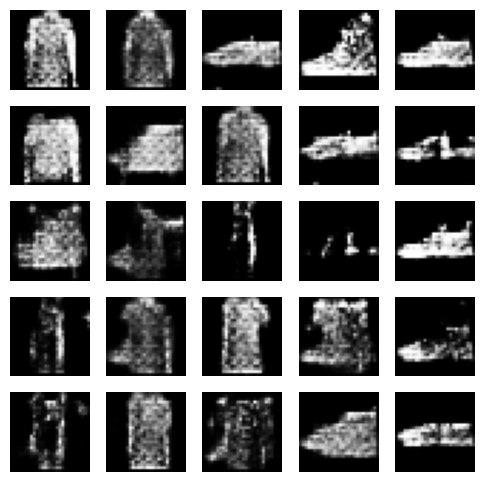

[20/100] gen_loss:1.4202; disc_loss:0.9236
[21/100] gen_loss:1.5251; disc_loss:0.9127
[22/100] gen_loss:1.3267; disc_loss:1.2094
[23/100] gen_loss:1.3757; disc_loss:0.8955
[24/100] gen_loss:1.2922; disc_loss:1.0395
[25/100] gen_loss:1.5113; disc_loss:0.8719
[26/100] gen_loss:1.4817; disc_loss:0.8744
[27/100] gen_loss:1.2491; disc_loss:0.9781
[28/100] gen_loss:1.5500; disc_loss:0.8539
[29/100] gen_loss:1.4530; disc_loss:0.9609
[30/100] gen_loss:1.1911; disc_loss:1.0284
[31/100] gen_loss:1.0555; disc_loss:1.0006
[32/100] gen_loss:1.0708; disc_loss:1.0516
[33/100] gen_loss:1.2426; disc_loss:1.0447
[34/100] gen_loss:1.2560; disc_loss:0.9642
[35/100] gen_loss:1.7390; disc_loss:0.7548
[36/100] gen_loss:1.2528; disc_loss:1.0583
[37/100] gen_loss:1.3322; disc_loss:0.9926
[38/100] gen_loss:1.1008; disc_loss:1.1548
[39/100] gen_loss:1.3119; disc_loss:1.0246


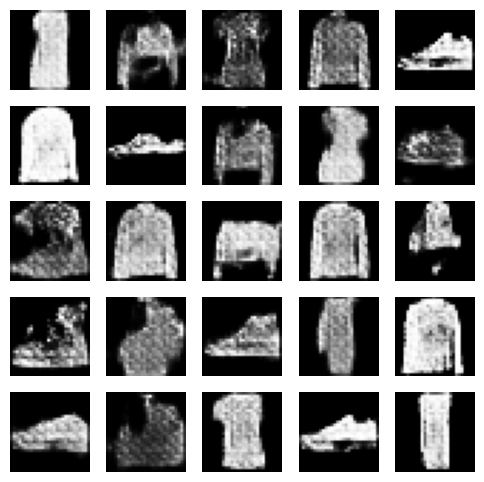

[40/100] gen_loss:1.4092; disc_loss:0.9287
[41/100] gen_loss:1.1515; disc_loss:0.9959
[42/100] gen_loss:1.1487; disc_loss:1.2188
[43/100] gen_loss:1.1330; disc_loss:0.9779
[44/100] gen_loss:1.1466; disc_loss:1.0484
[45/100] gen_loss:1.0252; disc_loss:1.1448
[46/100] gen_loss:1.2123; disc_loss:0.9774
[47/100] gen_loss:1.1571; disc_loss:1.0644
[48/100] gen_loss:1.0685; disc_loss:1.2074
[49/100] gen_loss:1.2672; disc_loss:1.0252
[50/100] gen_loss:0.9970; disc_loss:1.1255
[51/100] gen_loss:1.0718; disc_loss:1.1227
[52/100] gen_loss:1.2612; disc_loss:0.9592
[53/100] gen_loss:1.3728; disc_loss:0.9061
[54/100] gen_loss:1.1237; disc_loss:1.1311
[55/100] gen_loss:1.1109; disc_loss:1.1417
[56/100] gen_loss:0.8871; disc_loss:1.1966
[57/100] gen_loss:1.0302; disc_loss:1.1572
[58/100] gen_loss:1.1193; disc_loss:1.2207
[59/100] gen_loss:1.1151; disc_loss:1.0177


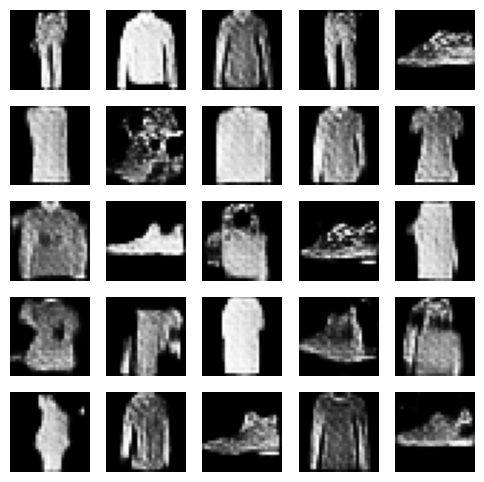

[60/100] gen_loss:1.0801; disc_loss:1.0562
[61/100] gen_loss:1.1497; disc_loss:1.1674
[62/100] gen_loss:1.1945; disc_loss:1.1781
[63/100] gen_loss:1.0650; disc_loss:1.1341
[64/100] gen_loss:0.9770; disc_loss:1.1285
[65/100] gen_loss:1.0364; disc_loss:1.1376
[66/100] gen_loss:1.0297; disc_loss:1.1503
[67/100] gen_loss:1.0854; disc_loss:1.1867
[68/100] gen_loss:1.0695; disc_loss:1.3258
[69/100] gen_loss:1.1332; disc_loss:1.1165
[70/100] gen_loss:1.0889; disc_loss:1.1132
[71/100] gen_loss:1.3181; disc_loss:1.2133
[72/100] gen_loss:1.0700; disc_loss:1.2588
[73/100] gen_loss:1.0450; disc_loss:1.1321
[74/100] gen_loss:1.5423; disc_loss:0.8910
[75/100] gen_loss:1.1674; disc_loss:1.0953
[76/100] gen_loss:0.9444; disc_loss:1.1785
[77/100] gen_loss:1.1230; disc_loss:1.1595
[78/100] gen_loss:0.9695; disc_loss:1.0877
[79/100] gen_loss:0.9151; disc_loss:1.1650


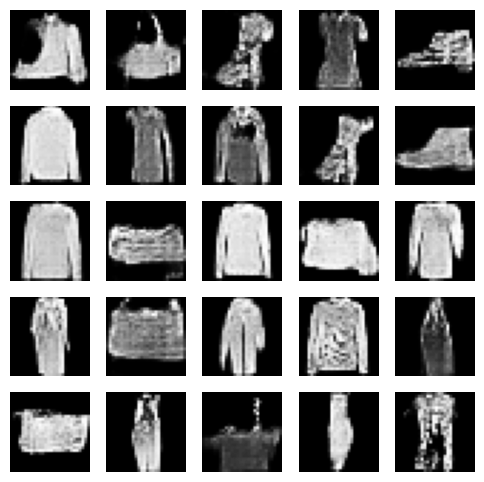

[80/100] gen_loss:0.9513; disc_loss:1.2642
[81/100] gen_loss:1.4989; disc_loss:0.8807
[82/100] gen_loss:1.0310; disc_loss:1.1097
[83/100] gen_loss:1.1233; disc_loss:1.1359
[84/100] gen_loss:0.9056; disc_loss:1.1740
[85/100] gen_loss:1.0384; disc_loss:1.2737
[86/100] gen_loss:0.9978; disc_loss:1.1716
[87/100] gen_loss:1.0352; disc_loss:1.2139
[88/100] gen_loss:1.0118; disc_loss:1.3068
[89/100] gen_loss:1.0204; disc_loss:1.2125
[90/100] gen_loss:0.9540; disc_loss:1.1655
[91/100] gen_loss:1.1438; disc_loss:1.2065
[92/100] gen_loss:0.8816; disc_loss:1.1754
[93/100] gen_loss:0.9413; disc_loss:1.1711
[94/100] gen_loss:1.0084; disc_loss:1.2128
[95/100] gen_loss:0.9602; disc_loss:1.2474
[96/100] gen_loss:1.3444; disc_loss:0.8768
[97/100] gen_loss:1.2823; disc_loss:1.0640
[98/100] gen_loss:1.0760; disc_loss:1.1216
[99/100] gen_loss:0.8898; disc_loss:1.2120


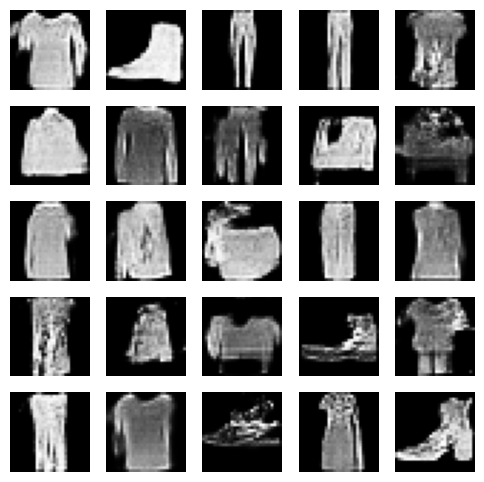

[100/100] gen_loss:0.8670; disc_loss:1.2554


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 定义模型参数
batch_size = 512
latent_dim = 100
epochs = 100
num_examples_to_generate = 25

# 加载数据集
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# 数据预处理
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  

# 定义生成器模型
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

# 定义判别器模型
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

# 定义生成器和判别器模型
generator = make_generator_model()
discriminator = make_discriminator_model()

# 定义交叉熵损失函数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 判别器损失函数
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# 生成器损失函数
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 定义优化器
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 定义训练函数
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# 定义生成样本函数
def generate_and_save_images(model, epoch, test_input, save_fig=True, show_fig=True):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=[6,6])

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    if save_fig:
        plt.savefig(f'generated_{epoch:04d}.png')
    if show_fig:
        plt.show()
    plt.close()

# 训练模型并可视化
def train_and_visualize(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        if (epoch+1) % 20 == 0:
            generate_and_save_images(generator, epoch+1, tf.random.normal([num_examples_to_generate, latent_dim]))

        print(f"[{epoch + 1}/{epochs}] gen_loss:{gen_loss:.4f}; disc_loss:{disc_loss:.4f}")

# 加载数据集并训练模型
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size=1024).batch(batch_size)
train_and_visualize(train_dataset, epochs)
